### Output vizualization

In [2]:
import numpy as np
import os
import torch
from time import time
from torch.autograd import Variable

import sys
sys.path.append('../')
from src.tilenet import make_tilenet
from src.resnet import ResNet18
import pandas as pd
from pathlib import Path
from osgeo import gdal

## load the pretrained model

since the authors pretrained tile2vec on 4 channels (and provided the checkpoints on 4 channels) firstly we will evaluate its performance only on 4 first channels of our data

In [3]:
# Setting up model
in_channels = 4
z_dim = 512
cuda = torch.cuda.is_available()
# tilenet = make_tilenet(in_channels=in_channels, z_dim=z_dim)
# Use old model for now
tilenet = ResNet18()
if cuda: tilenet.cuda()

In [ ]:
# Load parameters
model_fn = 'models/naip_trained.ckpt'
checkpoint = torch.load(model_fn)
tilenet.load_state_dict(checkpoint)
tilenet.eval()

In [4]:
# Get data
train_csv = '/storage/EuroSATallBands/train.csv'
train_df = pd.read_csv(train_csv)

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embedded 1 images
embedded 101 images
embedded 201 images
embedded 301 images
embedded 401 images
embedded 501 images
embedded 601 images
embedded 701 images
embedded 801 images
embedded 901 images
embedded 1001 images
embedded 1101 images
embedded 1201 images
embedded 1301 images
embedded 1401 images
embedded 1501 images
embedded 1601 images
embedded 1701 images
embedded 1801 images
embedded 1901 images
embedded 2001 images
embedded 2101 images
embedded 2201 images
embedded 2301 images
embedded 2401 images
embedded 2501 images
embedded 2601 images
embedded 2701 images
embedded 2801 images
embedded 2901 images
embedded 3001 images
embedded 3101 images
embedded 3201 images
embedded 3301 images
embedded 3401 images
embedded 3501 images
embedded 3601 images
embedded 3701 images
embedded 3801 images
embedded 3901 images
embedded 4001 images
embedded 4101 images
embedded 4201 images
embedded 4301 images
embedded 4401 images
embedded 4501 images
embedded 4601 images
embedded 4701 images
embe

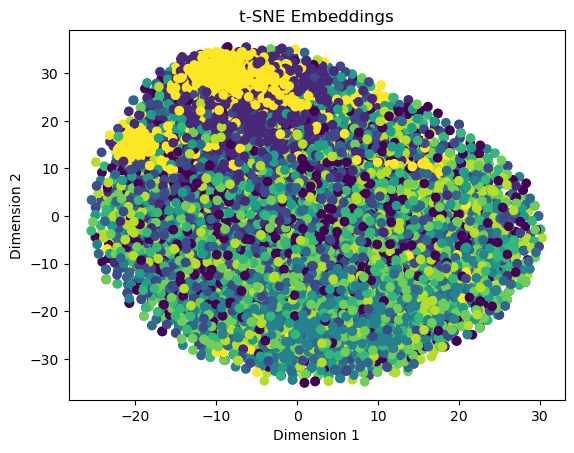

In [10]:
base_dir = Path("/storage/EuroSATallBands/")

t0 = time()
n_tiles = len(train_df)
X = np.zeros((n_tiles, z_dim))

# this solution to iterate over examples is very suboptimal, one should use torch dataset
for index, row in train_df.iterrows():
    # read the tile from provided filepath
    
    tile_filepath = base_dir / row["Filename"]
    obj = gdal.Open(tile_filepath)
    img = obj.ReadAsArray().astype(np.float32)
    img = np.moveaxis(img, 0, -1)

    tile = img[:, :, :4] # model supports for now only 4 channels

    tile = np.moveaxis(tile, -1, 0)
    tile = np.expand_dims(tile, axis=0)

    tile = tile / 255
    # Embed tile
    tile = torch.from_numpy(tile).float()
    tile = Variable(tile)
    if cuda: tile = tile.cuda()
    z = tilenet.encode(tile)
    if cuda: z = z.cpu()
    z = z.data.numpy()
    X[index,:] = z


    if index % 100 == 0:
        print(f"embedded {index+1} images")

# Get the labels
y = train_df["Label"].to_numpy()

t1 = time()
print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))

# Plot the t-SNE embeddings
embeddings_tsne = TSNE(n_components=2).fit_transform(X)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y)
plt.title("t-SNE Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()



## TSNEE

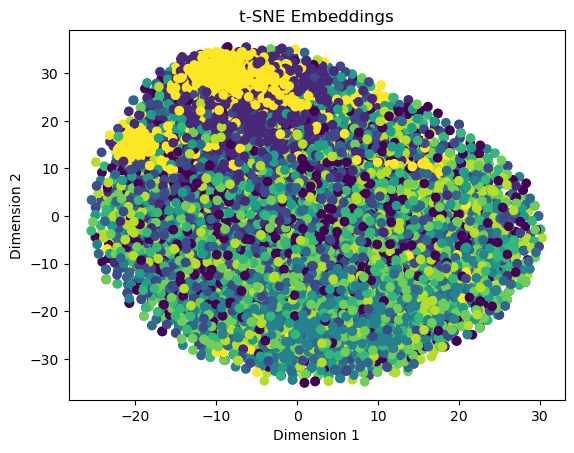

In [11]:
# Plot the t-SNE embeddings
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y)
plt.title("t-SNE Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

## PCA

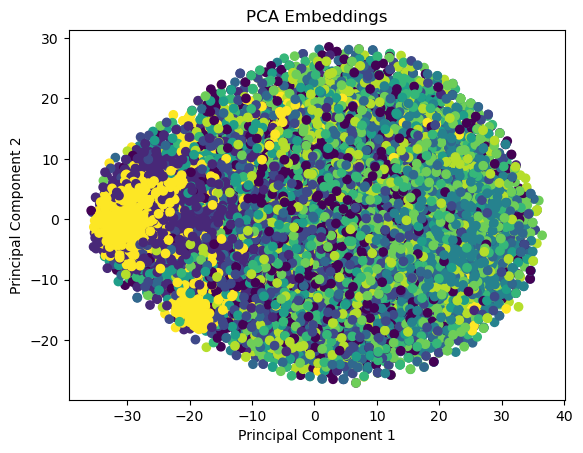

In [12]:
from sklearn.decomposition import PCA

# Perform PCA on the embeddings
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_tsne)

# Plot the PCA embeddings
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=y)
plt.title("PCA Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## UMAP

In [ ]:
#!pip install umap-learn

/home/maciej/.conda/envs/tile2vec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


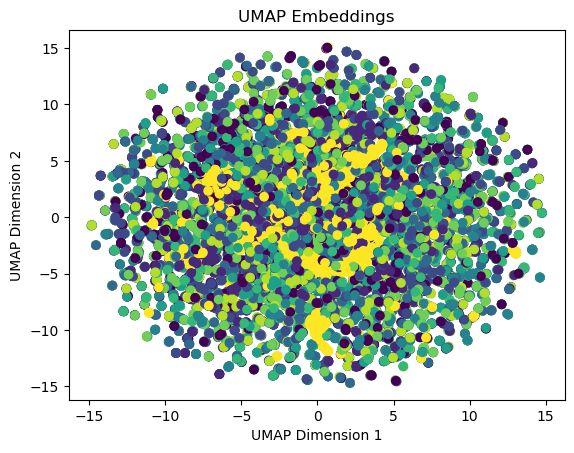

In [13]:
import umap

# Perform UMAP analysis on the embeddings
umap_embeddings = umap.UMAP(n_neighbors=5, min_dist=0.3).fit_transform(embeddings_tsne)

# Plot the UMAP embeddings
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y)
plt.title("UMAP Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()